In [1]:
# Constants and Configuration Variables
DEBUG = True
TRAIN = True
TUNING = True
OVERWRITE_PROCESSED_DATA = True
N_TRIALS = 10
STATE = 42

GPU_SWITCH = "OFF"
N_SPLITS = 7
N_TEST_SPLITS = 1
N_PURGE = 11
N_EMBARGO = 11


VERSION_NB = 11
EXPERIMENT_PURPOSE = "optiver_trading_at_the_close"

model_params_dict = {
    "LGBMR": {
        "static_params": {
            "device": "gpu" if GPU_SWITCH == "ON" else "cpu",
            "objective": "mae",
            "boosting_type": "gbdt",
            "random_state": STATE,
            "n_jobs": 4,
            "verbose": -1,
            "importance_type": "gain",
        },
        "dynamic_params": {
            "n_estimators": {
                "type": "int",
                "low": 4052,
                "high": 4052,
            },
            "learning_rate": {
                "type": "float",
                "low": 0.012,
                "high": 0.012,
            },
            "max_depth": {"type": "int", "low": 49, "high": 49},
            "num_leaves": {
                "type": "int",
                "low": 63,
                "high": 63,
            },
            "min_child_samples": {
                "type": "int",
                "low": 23,
                "high": 23,
            },
            "subsample": {
                "type": "float",
                "low": 1,
                "high": 1,
            },
            "colsample_bytree": {
                "type": "float",
                "low": 1,
                "high": 1,
            },
        },
    },
}

# RECORD ENSAMBLE MODEL
model_paths = [
    "s3://mlflow-v1/kaggle_optiver_trading_at_the_close/0f6ce4df6744464bbd4123566a088d27/artifacts/LGBMR_0_20231114_095007/model.pkl",
    "s3://mlflow-v1/kaggle_optiver_trading_at_the_close/47d294f60f9642248cb2d0fb8ccd9bf6/artifacts/LGBMR_0_20231114_100521/model.pkl",
    "s3://mlflow-v1/kaggle_optiver_trading_at_the_close/9431eeeeaf6b4690a6a11d9b9d0ad52a/artifacts/LGBMR_0_20231114_101915/model.pkl",
    "s3://mlflow-v1/kaggle_optiver_trading_at_the_close/e603fb30d1b04756b34e443325924da4/artifacts/LGBMR_0_20231114_103413/model.pkl",
    "s3://mlflow-v1/kaggle_optiver_trading_at_the_close/748ddac91acf4ead85cc0f567d053596/artifacts/LGBMR_0_20231114_104931/model.pkl",
    "s3://mlflow-v1/kaggle_optiver_trading_at_the_close/814b2dc76eb14d57a80a79e100c50c3a/artifacts/LGBMR_0_20231114_110439/model.pkl",
    "s3://mlflow-v1/kaggle_optiver_trading_at_the_close/5ab9ade2bcdb46e8bd86ae1e5f8f2df4/artifacts/LGBMR_0_20231114_111703/model.pkl",
]

# Define the model name for registration in MLflow

model_name = f"ensemble_model (7)"
folder_model = f"models-v8"

In [2]:
# External general-purpose modules
import gc
import sys
import os
import itertools as itt
from itertools import combinations, product
from datetime import datetime
import numpy as np
import pandas as pd
import polars as pl
import joblib

from pathlib import Path
import warnings
from numba import njit, prange
import boto3
from botocore.exceptions import NoCredentialsError
from dotenv import load_dotenv


# Setting pandas options and warning filters
pd.set_option("display.max_columns", None)
warnings.filterwarnings("ignore")
warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

# Load environment variables
load_dotenv()
path_root_project = Path.cwd()
if path_root_project.name not in ["working", "content"]:
    path_root_project = Path(os.getenv("ROOT_PATH") or path_root_project)

    directories_to_add = ["utils", "feat_engineering", "validation"]
    for directory in directories_to_add:
        sys.path.append(str(path_root_project / "src" / directory))


from utils_training import create_model, experiments_data
from utils_data import load_config, load_dataset, reduce_mem_usage, PathManager
from utils_kaggle import (
    setup_kaggle,
    download_data,
    get_data,
    clean_directory_except_one,
)

from fe_optiver_trading_at_the_close import (
    calculate_triplet_imbalance_numba,
    convert_weights_to_dict,
    global_stock_id_feats,
    compute_rolling_averages,
    generate_rsi,
)

pm = PathManager(path_root_project)

if TRAIN:
    if pm.path_root_project.name == "working":
        from kaggle_secrets import UserSecretsClient

        user_secrets = UserSecretsClient()
        aws_access_key_id = user_secrets.get_secret("AWS_ACCESS_KEY_ID")
        aws_region = user_secrets.get_secret("AWS_DEFAULT_REGION")
        aws_secret_access_key = user_secrets.get_secret("AWS_SECRET_ACCESS_KEY")
        s3_bucket_name = user_secrets.get_secret("S3_BUCKET")

        # Set AWS credentials in the environment variables
        os.environ["AWS_ACCESS_KEY_ID"] = aws_access_key_id
        os.environ["AWS_SECRET_ACCESS_KEY"] = aws_secret_access_key
        os.environ["AWS_DEFAULT_REGION"] = aws_region
    else:
        aws_access_key_id = os.getenv("AWS_ACCESS_KEY_ID")
        aws_secret_access_key = os.getenv("AWS_SECRET_ACCESS_KEY")

In [3]:
# model_prod = joblib.load('/kaggle/input/{folder_model}/{model_name}')

In [4]:


# Conditional imports and settings based on TRAIN constant
if TRAIN:
    if pm.path_root_project.name == "working":
        !pip install loguru mlflow optuna > /dev/null

    

    from utils_mlflow import (
        get_experiments_df,
        delete_runs_and_artifacts,
        download_and_load_model,
        load_models_and_create_ensemble,
        save_and_register_model,
        log_model_parameters,
        get_or_create_experiment,
        experiments_data,
    )
    from utils_feat_importance import log_feature_importance, aggregate_feature_importance
    from model_validation import time_series_split

    # External Libraries
    import boto3
    from botocore.exceptions import NoCredentialsError
    from mlflow.exceptions import MlflowException
    import lightgbm as lgbm
    import mlflow
    import optuna
    from mlflow.tracking import MlflowClient
    from optuna.integration.mlflow import MLflowCallback
    from sklearn.model_selection import KFold
    from xgboost import XGBRegressor as XGBR
    from lightgbm import log_evaluation, early_stopping, LGBMRegressor as LGBMR



    # Auto-reload modules - Specific to Jupyter Notebooks
    %load_ext autoreload
    %autoreload 2

    mlflow.set_tracking_uri(pm.path_experiments_dir)
    client = MlflowClient()
    
    # Create an S3 client
    s3 = boto3.client(
        "s3",
        aws_access_key_id=aws_access_key_id,
        aws_secret_access_key=aws_secret_access_key,
    )

In [5]:
# if TRAIN:
#     s3 = boto3.client(
#         "s3",
#         aws_access_key_id=aws_access_key_id,
#         aws_secret_access_key=aws_secret_access_key,
#     )
#     # Load the models and create an ensemble
#     ensemble_model = load_models_and_create_ensemble(s3, model_paths)

#     # Save and register the ensemble model in MLflow
#     save_and_register_model(ensemble_model, model_name)

In [10]:
if TRAIN:
    if not os.path.exists(pm.path_dataset_processed) or OVERWRITE_PROCESSED_DATA:
        df_train_raw = pd.read_csv(pm.path_data_train_raw)

        if DEBUG:
            df_train_raw = df_train_raw[df_train_raw["stock_id"].isin([0, 1, 2, 3, 4])]

        drop_idx = df_train_raw.loc[
            df_train_raw["target"].isna(), "target"
        ].index.to_list()
        df_train = df_train_raw.drop(drop_idx, axis=0)
        df_train.reset_index(drop=True, inplace=True)
    else:
        df_train = pd.read_csv(pm.path_dataset_processed)
        if DEBUG:
            df_train = df_train[df_train["stock_id"].isin([0, 1, 2, 3, 4])]

In [11]:
df_train.sort_values(["time_id", "stock_id"], inplace=True)

In [12]:
df_train.to_csv("campione.csv", index=False)

In [13]:
target_col = 'target'
cols_features = [cols for cols in df_train.columns if cols not in [target_col, "time_id", "row_id", "target_prev"]]

In [14]:
mask_train = df_train["time_id"] < 400
mask_test = df_train["time_id"] >= 400

y_train = df_train.loc[mask_train, target_col]
y_val = df_train.loc[mask_test, target_col]
X_train = df_train.loc[mask_train, cols_features]
X_val = df_train.loc[mask_test, cols_features]

In [19]:
import lightgbm as lgb
model = lgb.LGBMRegressor(
    num_leaves=3, 
    learning_rate=0.05, 
    n_estimators=3
)

# dict_params = {
#                 "n_estimators": 5,
#                 "learning_rate": 0.01,
#                 "max_depth": 3,
#                 "num_leaves": 20,
#                 "min_child_samples": 10,
#                 "subsample": 0.7,
#                 "colsample_bytree": 1.0,
#                 "min_split_gain": 0.0,
#                 "reg_alpha": 0.0,
#                 "reg_lambda": 0.0,
#                 "device": "cpu",
#             }

# model = LGBMR(**dict_params)

model.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="mae",
    callbacks=[
        lgbm.callback.early_stopping(stopping_rounds=100),
        lgbm.callback.log_evaluation(period=100000),
    ],
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2611
[LightGBM] [Info] Number of data points in the train set: 2000, number of used features: 14
[LightGBM] [Info] Start training from score 0.191202
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[2]	valid_0's l1: 5.84957	valid_0's l2: 71.1457


LGBMRegressor(learning_rate=0.05, n_estimators=3, num_leaves=3)

In [20]:
model.feature_importances_

array([0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0], dtype=int32)

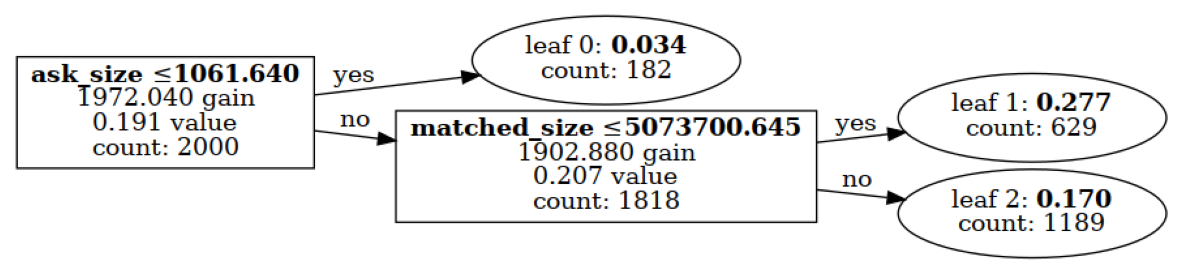

In [21]:
import lightgbm as lgb
import matplotlib.pyplot as plt

# Assuming you have a trained LightGBM model 'lgb_model'
# Plot the first tree
ax = lgb.plot_tree(model, tree_index=0, figsize=(15, 8), show_info=['split_gain', 'internal_value', 'internal_count', 'leaf_count'])
plt.show()

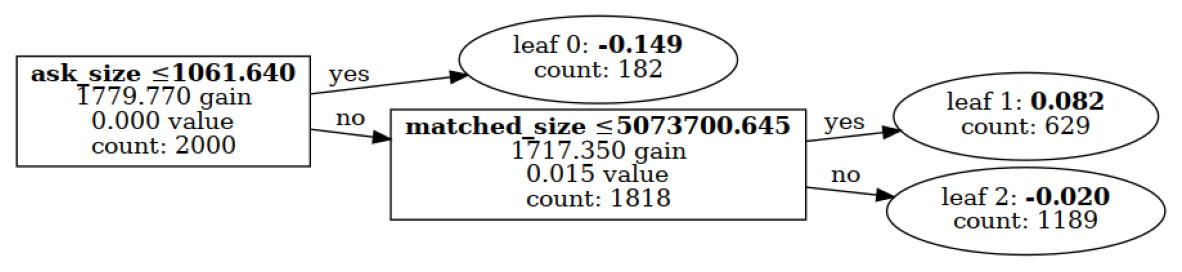

In [22]:
import lightgbm as lgb
import matplotlib.pyplot as plt

# Assuming you have a trained LightGBM model 'lgb_model'
# Plot the first tree
ax = lgb.plot_tree(model, tree_index=1, figsize=(15, 8), show_info=['split_gain', 'internal_value', 'internal_count', 'leaf_count'])
plt.show()

In [29]:
import yfinance as yf
import pandas as pd

# Download historical data for Apple
aapl_data = yf.download('AAPL', start='2023-01-01', end='2023-11-17')

# Calculate Previous_Close and Return
aapl_data['Previous_Close'] = aapl_data['Close'].shift(1)
aapl_data['Return'] = (aapl_data['Close'] - aapl_data['Previous_Close']) / aapl_data['Previous_Close'] * 100

# Resetting the index to make 'Date' a column
aapl_data.reset_index(inplace=True)

# Select only the required columns
aapl_data = aapl_data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Previous_Close', 'Return']]

# Optionally, save to


[*********************100%%**********************]  1 of 1 completed


In [30]:
aapl_data

,Date,Open,High,Low,Close,Volume,Previous_Close,Return
0,2023-01-03,130.279999,130.899994,124.169998,125.070000,112117500,NaN,NaN
1,2023-01-04,126.889999,128.660004,125.080002,126.360001,89113600,125.070000,1.031423
2,2023-01-05,127.129997,127.769997,124.760002,125.019997,80962700,126.360001,-1.060465
3,2023-01-06,126.010002,130.289993,124.889999,129.619995,87754700,125.019997,3.679410
4,2023-01-09,130.470001,133.410004,129.889999,130.149994,70790800,129.619995,0.408887
...,...,...,...,...,...,...,...,...
215,2023-11-09,182.960007,184.119995,181.809998,182.410004,53763500,182.889999,-0.262451
216,2023-11-10,183.970001,186.570007,183.529999,186.399994,66133400,182.410004,2.187375
217,2023-11-13,185.820007,186.029999,184.210007,184.800003,43627500,186.399994,-0.858364
218,2023-11-14,187.699997,188.110001,186.300003,187.440002,60108400,184.800003,1.428571


In [31]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset (replace with your dataset's path)
data = aapl_data.copy()
# Handle missing values if any
data.dropna(inplace=True)

# Define features and target variable
# Assuming 'Return' is the target variable
X = data[['Open', 'High', 'Low', 'Close', 'Volume']]
y = data['Return']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [34]:
from sklearn.ensemble import RandomForestRegressor

# Initialize and train the Random Forest model
# Here, using RandomForestRegressor; you can use RandomForestClassifier if needed
model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth = 4)
model.fit(X_train, y_train)


RandomForestRegressor(max_depth=4, random_state=42)

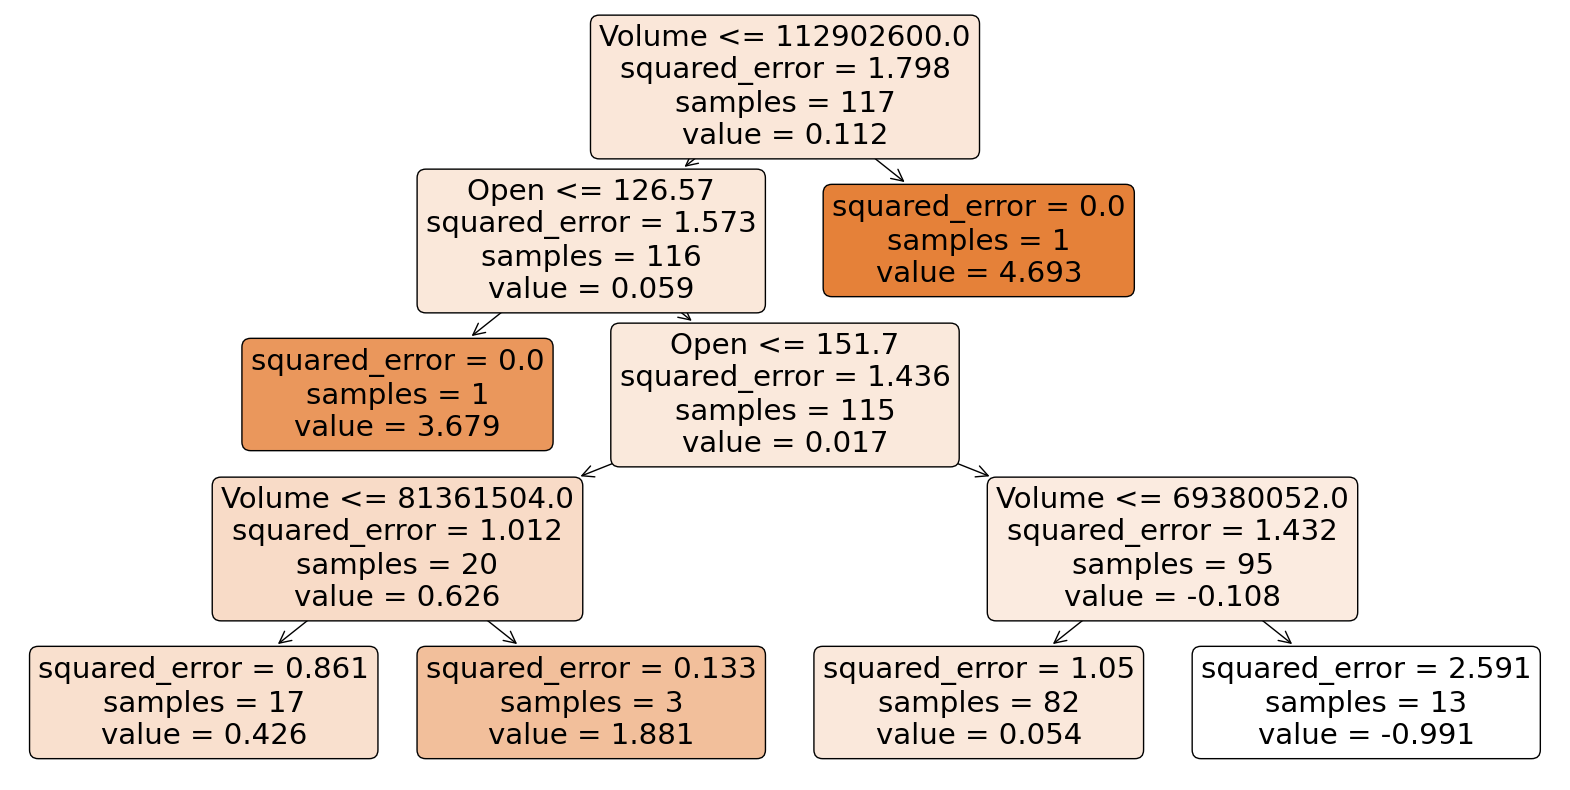

In [35]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Extract the first tree from the random forest model
first_tree = model.estimators_[0]

# Plot the tree
plt.figure(figsize=(20,10))
plot_tree(first_tree, 
          feature_names=X.columns, 
          filled=True, 
          rounded=True, 
          class_names=True)
plt.show()


In [24]:
!pip install yfinance


  Obtaining dependency information for yfinance from https://files.pythonhosted.org/packages/e6/b3/388ab967a387cc92926f70e97688dd9a7189b29a0773db815ffc5289e2b5/yfinance-0.2.31-py2.py3-none-any.whl.metadata
  Obtaining dependency information for lxml>=4.9.1 from https://files.pythonhosted.org/packages/3c/d2/11533f0bc47ff4d828a20cfb702f3453fe714bd5b475fcdc8cec6e6b7dcf/lxml-4.9.3-cp310-cp310-manylinux_2_28_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 13.2 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.0/143.0 kB 23.8 MB/s eta 0:00:00
  Using cached html5lib-1.1-py2.py3-none-any.whl (112 kB)
  Obtaining dependency information for soupsieve>1.2 from https://files.pythonhosted.org/packages/4c/f3/038b302fdfbe3be7da0167770

In [9]:
if TRAIN:
    global_stock_id_feats = global_stock_id_feats(df_train)

In [10]:
def aggregate_feature_importance(list_files_feat_importance):
    list_of_dfs = []
    for file_path in list_files_feat_importance:
        feature_importance_df = pd.read_csv(file_path)

        folds = [col for col in feature_importance_df.columns if "imp_fold" in col]

        # Normalize by dividing each score by the sum of scores within its respective fold
        for fold in folds:
            fold_sum = feature_importance_df[fold].sum()
            feature_importance_df[fold] = feature_importance_df[fold] / fold_sum

        list_of_dfs.append(feature_importance_df)

    aggregated_df = pd.concat(list_of_dfs, ignore_index=True)

    df_median_importance = aggregated_df.groupby("feat").median().reset_index()

    df_median_importance["feat_imp_overall_mean"] = df_median_importance.loc[
        :, df_median_importance.columns != "feat"
    ].median(axis=1, skipna=True)
    cols = ["feat", "feat_imp_overall_mean"] + [
        col
        for col in df_median_importance.columns
        if col not in ["feat_imp_overall_mean", "feat"]
    ]
    df_median_importance = df_median_importance[cols]

    df_median_importance.sort_values(
        "feat_imp_overall_mean", ascending=False, inplace=True
    )
    return df_median_importance

In [11]:
# aggregate_feature_importance(['/kaggle/working/feat_impor_optiver_trading_at_the_close_23_11_13_2032.csv']).tail(20)

In [12]:
# df_experiments = get_experiments_df(client)

# experiment_ids_to_remove = [
#     "999333986568643837",
#     "867182202959923683",
#     "773486292991054569",
#     "195291970476306379",
# ]
# delete_runs_and_artifacts(client, experiment_ids_to_remove, s3_bucket_name)

CPU times: user 515 µs, sys: 43 µs, total: 558 µs
Wall time: 541 µs


In [18]:
# generate imbalance features
def imbalance_features(df):
    prices = [
        "reference_price",
        "far_price",
        "near_price",
        "ask_price",
        "bid_price",
        "wap",
        "imbalance_size",
    ]
    sizes = ["matched_size", "bid_size", "ask_size", "imbalance_size"]

    # V1
    df["volume"] = df.eval("ask_size + bid_size")
    df["mid_price"] = df.eval("(ask_price + bid_price) / 2")
    df["liquidity_imbalance"] = df.eval("(bid_size-ask_size)/(bid_size+ask_size)")
    df["matched_imbalance"] = df.eval(
        "(imbalance_size-matched_size)/(matched_size+imbalance_size)"
    )
    df["size_imbalance"] = df.eval("bid_size / ask_size")

    for c in combinations(prices, 2):
        df[f"{c[0]}_{c[1]}_imb"] = df.eval(f"({c[0]} - {c[1]})/({c[0]} + {c[1]})")

    for c in [["ask_price", "bid_price", "wap", "reference_price"], sizes]:
        triplet_feature = calculate_triplet_imbalance_numba(c, df)
        df[triplet_feature.columns] = triplet_feature.values

    # V2
    weights = convert_weights_to_dict()
    df["stock_weights"] = df["stock_id"].map(weights)
    df["weighted_wap"] = df["stock_weights"] * df["wap"]
    df["wap_momentum"] = df.groupby("stock_id")["weighted_wap"].pct_change(periods=6)
    df["imbalance_momentum"] = (
        df.groupby(["stock_id"])["imbalance_size"].diff(periods=1) / df["matched_size"]
    )
    df["price_spread"] = df["ask_price"] - df["bid_price"]
    df["spread_intensity"] = df.groupby(["stock_id"])["price_spread"].diff()
    df["price_pressure"] = df["imbalance_size"] * (df["ask_price"] - df["bid_price"])
    df["market_urgency"] = df["price_spread"] * df["liquidity_imbalance"]
    df["depth_pressure"] = (df["ask_size"] - df["bid_size"]) * (
        df["far_price"] - df["near_price"]
    )
    df["spread_depth_ratio"] = (df["ask_price"] - df["bid_price"]) / (
        df["bid_size"] + df["ask_size"]
    )
    df["mid_price_movement"] = (
        df["mid_price"]
        .diff(periods=5)
        .apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
    )
    df["micro_price"] = (
        (df["bid_price"] * df["ask_size"]) + (df["ask_price"] * df["bid_size"])
    ) / (df["bid_size"] + df["ask_size"])
    df["relative_spread"] = (df["ask_price"] - df["bid_price"]) / df["wap"]

    # V4 features - Rolling averages
    window_sizes = [6]  # Define your desired window sizes
    list_cols = ["wap", "imbalance_size"]
    for price in prices:
        rolling_avg_features = compute_rolling_averages(
            df[price].values.reshape(-1, 1), window_sizes
        )

        # Assigning the rolling average results to the DataFrame
        for i, window in enumerate(window_sizes):
            column_name = f"{price}_rolling_avg_{window}"
            df[column_name] = rolling_avg_features[:, 0, i]

    # Patching the start-of-day values after all rolling averages are calculated
    for window in window_sizes:
        for idx, seconds in enumerate(df["seconds_in_bucket"].values):
            if seconds / 10 <= window:
                for price in prices:
                    column_name = f"{price}_rolling_avg_{window}"
                    df.at[idx, column_name] = df.at[idx, price]

    for func in ["mean", "std", "skew", "kurt"]:
        df[f"all_prices_{func}"] = df[prices].agg(func, axis=1)
        df[f"all_sizes_{func}"] = df[sizes].agg(func, axis=1)

    # V3
    for col in [
        "matched_size",
        "imbalance_size",
        "reference_price",
        "imbalance_buy_sell_flag",
    ]:
        for window in [1, 2, 3, 5, 10]:
            df[f"{col}_shift_{window}"] = df.groupby(["stock_id"])[col].shift(window)
            df[f"{col}_ret_{window}"] = df.groupby(["stock_id"])[col].pct_change(window)

    for col in [
        "ask_price",
        "bid_price",
        "ask_size",
        "bid_size",
        "wap",
        "near_price",
        "far_price",
        "market_urgency",
    ]:
        for window in [1, 2, 3, 5, 10]:
            df[f"{col}_diff_{window}"] = df.groupby(["stock_id"])[col].diff(window)

    return df.replace([np.inf, -np.inf], 0)


# generate time & stock features
def other_features(df):
    df["dow"] = df["date_id"] % 5
    df["dom"] = df["date_id"] % 20
    df["seconds"] = df["seconds_in_bucket"] % 60
    df["minute"] = df["seconds_in_bucket"] // 60

    for key, value in global_stock_id_feats.items():
        df[f"global_{key}"] = df["stock_id"].map(value.to_dict())

    return df


# generate all features
def feat_engineering(df):
    df.reset_index(inplace=True, drop=True)
    cols = [c for c in df.columns if c not in ["row_id"]]
    df = df[cols]
    df = imbalance_features(df)
    df = other_features(df)

    df = generate_rsi(df)
    df = generate_macd(df)
    gc.collect()

    list_cols = [
        i
        for i in df.columns
        if i
        not in ["row_id"]
        + [
            "depth_pressure",
            "bid_size_diff_5",
            "ask_size_diff_5",
            "ask_size_diff_10",
            "imbalance_buy_sell_flag_ret_5",
            "imbalance_buy_sell_flag_ret_10",
            "imbalance_buy_sell_flag_ret_3",
            "imbalance_buy_sell_flag_ret_2",
            "minute",
            "bid_size_diff_3",
            "bid_size_diff_10",
            "ask_price_diff_10",
            "bid_price_diff_10",
            "macd_hist_far_price",
            "macd_far_price",
            "macd_sig_near_price",
            "macd_sig_far_price",
            "macd_near_price",
            "macd_hist_near_price",
            "bid_size_diff_2",
            "volume",
            "wap_diff_10",
            "imbalance_buy_sell_flag_ret_1",
            "bid_size_ask_size_imbalance_size_imb2",
            "ask_size_diff_2",
        ]
    ]

    return df[list_cols]

In [19]:
if TRAIN:
    df_train_feats = feat_engineering(df_train)
    print("Build Online Train Feats Finished.")

    df_train_feats = reduce_mem_usage(df_train_feats)

In [20]:
if TRAIN:
    col_split = "time_id"
    df_train_feats.sort_values([col_split], inplace=True)
    df_train_feats.reset_index(drop=True, inplace=True)
    df_train_feats["factorized"] = pd.factorize(df_train_feats[col_split])[0]

    list_cols_drop = ["date_id", "time_id"]
    df_train_feats.drop(list_cols_drop, axis=1, inplace=True)

In [21]:
if TRAIN:
    experiment_name = f"{EXPERIMENT_PURPOSE}_v{VERSION_NB}"
    name_folder_models = f"models_v{VERSION_NB}"

    experiment_date_str = datetime.now().strftime("%y_%m_%d_%H%M")
    experiment_id = get_or_create_experiment(
        client, experiment_name, artifact_location=pm.path_artifact_location
    )

    nbrnd_erly_stp = 130
    cv_mthd = "KF"

    # Cross-Validation Setup
    if TRAIN:
        # Initialize MLflow callback
        mlflow_callback = MLflowCallback(
            tracking_uri=mlflow.get_tracking_uri(), metric_name="mae"
        )

        all_cv = {"KF": KFold(n_splits=5, shuffle=True, random_state=STATE)}
        cv = all_cv[cv_mthd]

        dict_models = {"LGBMR": LGBMR}

        log_model = True

    if TRAIN:
        args = {
            "cv_mthd": cv_mthd,
            "experiment_purpose": EXPERIMENT_PURPOSE,
            "experiment_name": experiment_name,
            "dict_models": dict_models,
            "model_params_dict": model_params_dict,
            "n_splits": N_SPLITS,
            "n_test_splits": N_TEST_SPLITS,
            "n_purge": N_PURGE,
            "n_embargo": N_EMBARGO,
            "experiment_date_str": experiment_date_str,
            "path_artifact_location": pm.path_artifact_location,
            "target_col": "target",
        }

In [22]:
def run_mlflow_experiment(df_train, args, trial=None):
    cv_mthd = args["cv_mthd"]
    experiment_purpose = args["experiment_purpose"]
    experiment_name = args["experiment_name"]
    dict_models = args["dict_models"]
    model_params_dict = args["model_params_dict"]

    n_splits = args["n_splits"]
    n_test_splits = args["n_test_splits"]
    n_purge = args["n_purge"]
    n_embargo = args["n_embargo"]

    experiment_date_str = args["experiment_date_str"]
    path_artifact_location = args["path_artifact_location"]
    target_col = args["target_col"]

    if trial == None:
        trial = optuna.trial.FixedTrial(
            {
                "n_estimators": 500,
                "learning_rate": 0.005,
                "max_depth": 10,
                "num_leaves": 20,
                "min_child_samples": 10,
                "subsample": 0.7,
                "colsample_bytree": 1.0,
                "min_split_gain": 0.0,
                "reg_alpha": 0.0,
                "reg_lambda": 0.0,
                "device": "gpu" if gpu_switch == "ON" else "cpu",
            }
        )

    run_time_start_trial = datetime.now().strftime("%y_%m_%d_%H%M%S")

    with mlflow.start_run(
        run_name=run_time_start_trial, experiment_id=experiment_id
    ) as run:
        score_list = []

        # mlflow.set_tag("cv_mthd", cv_mthd)
        mlflow.set_tag("n_splits", n_splits)
        mlflow.set_tag("n_test_splits", n_test_splits)
        mlflow.set_tag("n_purge", n_purge)
        mlflow.set_tag("n_embargo", n_embargo)

        for model_name, model_class in dict_models.items():
            if TUNING:
                model = create_model(
                    trial,
                    model_class,
                    model_params_dict[model_name]["static_params"],
                    model_params_dict[model_name]["dynamic_params"],
                )
            else:
                params = model_prod.get_params()
                params["device"] = "gpu"

                model = model_class(**params)

            priority_params = ["learning_rate", "max_depth"]
            excluded_params = [
                "device",
                "class_weight",
                "random_state",
                "silent",
                "verbose",
                "n_jobs",
            ]

            ordered_params = log_model_parameters(
                model, priority_params, excluded_params, verbose=True
            )

            mlflow.log_params(ordered_params)

            for fold_n, (train_indices, test_indices) in enumerate(
                time_series_split(
                    df_train,
                    n_splits=n_splits,
                    n_test_splits=n_test_splits,
                    n_purge=n_purge,
                    n_embargo=n_embargo,
                )
            ):
                # if fold_n == 0:
                with mlflow.start_run(
                    run_name=f"fold_{fold_n+1}",
                    nested=True,
                    experiment_id=experiment_id,
                ) as nested_run:
                    mlflow.set_tag("n_trial", str(trial.number))

                    mask_train = df_train["factorized"].isin(train_indices)
                    mask_test = df_train["factorized"].isin(test_indices)

                    y_train = df_train.loc[mask_train, target_col]
                    y_val = df_train.loc[mask_test, target_col]
                    X_train = df_train.loc[mask_train].drop(
                        [target_col, "factorized"], axis=1
                    )
                    X_val = df_train.loc[mask_test].drop(
                        [target_col, "factorized"], axis=1
                    )

                    mlflow.log_param("train_rows", X_train.shape[0])
                    mlflow.log_param("train_cols", X_train.shape[1])

                    model.fit(
                        X_train,
                        y_train,
                        eval_set=[(X_val, y_val)],
                        eval_metric="mae",
                        callbacks=[
                            lgbm.callback.early_stopping(stopping_rounds=100),
                            lgbm.callback.log_evaluation(period=100000),
                        ],
                    )

                    log_feature_importance(
                        trial.number,
                        model,
                        X_train,
                        fold_n,
                        experiment_purpose,
                        experiment_date_str,
                    )

                    fold_score = model.best_score_["valid_0"]["l1"]

                    score_list.append(fold_score)

                    mlflow.log_metric("fold_score", round(fold_score, 6))
                    mlflow.log_param("fold_number", fold_n + 1)
                    mlflow.log_param("model_name", model_name)

                    mlflow.log_params(ordered_params)

                    current_time_str = datetime.now().strftime("%Y%m%d_%H%M%S")
                    model_log_name = f"{model_name}_{trial.number}_{current_time_str}"

                    mlflow.sklearn.log_model(model, model_log_name)

                    mlflow.log_param("run_time", current_time_str)

                    nested_run_id = nested_run.info.run_id
                    model_path = f"{path_artifact_location}/{run.info.experiment_id}/{nested_run_id}/artifacts/{model_log_name}/model.pkl"
                    mlflow.log_param("model_path", model_path)

                avg_score = sum(score_list) / len(score_list)
                median_score = np.median(score_list)
                mlflow.log_metric("avg score", round(avg_score, 6))
                mlflow.log_metric("median score", round(median_score, 6))

        return avg_score


def objective(trial, df_train):
    avg_score = run_mlflow_experiment(df_train, args, trial)
    return avg_score


# Run the Optuna study
if TRAIN:
    study = optuna.create_study(
        direction="minimize",
        study_name="Your Study Name",
        load_if_exists=True,
    )
    study.optimize(lambda trial: objective(trial, df_train_feats), n_trials=N_TRIALS)

In [23]:
if TRAIN:
    df_exp = experiments_data(
        client, list_experiment_id=None, save_df=None, list_columns=None
    )
    list_base_cols = [
        "run_time",
        "experiment_id",
        "n_trial",
        "run_id",
        "model_name",
        "fold_number",
        "fold_score",
    ]
    list_dynamic_params = list(model_params_dict["LGBMR"]["dynamic_params"].keys())

    df_exp["run_time"] = pd.to_datetime(
        df_exp["run_time"], format="%Y%m%d_%H%M%S", errors="coerce"
    )

    for col in df_exp.columns:
        df_exp[col] = pd.to_numeric(df_exp[col], errors="ignore")

    for col in df_exp.select_dtypes(include=["float", "int"]):
        df_exp[col] = df_exp[col].round(5)

    list_cols_exp = ["run_time"] + list_base_cols + list_dynamic_params + ["model_path"]

    experiment_id
    df_exp = df_exp[df_exp["experiment_id"] != 0]

    df_exp = df_exp[list_cols_exp]

In [24]:
import optiver2023

env = optiver2023.make_env()
iter_test = env.iter_test()

In [25]:
df_train = pd.read_csv("/kaggle/input/optiver-trading-at-the-close/train.csv")

In [26]:
global_stock_id_feats = global_stock_id_feats(df_train)

In [27]:
counter = 0
df_tot_test = []
for test, revealed_targets, sample_prediction in iter_test:
    test["time_id"] = counter
    test["target"] = "none"

    if counter < 12:
        df_tot_test.append(test)
    else:
        df_tot_test = df_tot_test[1:]
        df_tot_test.append(test)

    df_test = pd.concat(df_tot_test, axis=0, ignore_index=True)

    feat = feat_engineering(df_test)
    feat = feat.sort_values(["date_id", "seconds_in_bucket", "stock_id"])[-len(test) :]

    list_cols_drop = ["date_id"]
    feat.drop(list_cols_drop, axis=1, inplace=True)

    list_features = model_prod.models[0].feature_name_
    feat = feat[list_features]
    sample_prediction["target"] = model_prod.predict(feat, "median")
    env.predict(sample_prediction)
    counter += 1

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


In [ ]:
# clean_directory_except_one('/kaggle/working/','submission.csv')